In [41]:
import pickle
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from collections import Counter
import umap
import networkx as nx
from itertools import permutations 
import hdbscan
import numpy as np
from mechanism_solver import MechanismAStarSolver, MechanismDynamicSolver
from approval_profile import *
from mechanism import *

In [77]:
def axiom(projects, ballots, labels, costs, budget):
    n_clusters = max(labels) + 1
    clusters = [ballots[labels == i] for i in range(n_clusters)]
    b = [] 
    r = []
    for cluster in clusters:
        b.append(np.sum(np.mean(cluster,0)[projects]*costs[projects])/budget)
        r.append(len(cluster)/len(ballots))
    b = np.array(b)
    b /= sum(b)
    s = 0
    for x,y in zip(b,r):
        s += np.abs(x-y)**2
        print(f"{(x-y):.3f}")
    print(s)


In [2]:
profile = Profile_Synthetic(list(range(60000, 100, -3000)), list(range(10000, 1, -1000)), budget_distribution=uniform, low=500, high=10000)


In [8]:
profile = Profile_Synthetic.load('gen_data//55000_20_liniear.pb')
data = profile.ballots
old_clusters = profile.clusters
old_labels = [j for i,cluster in enumerate(old_clusters) for j in len(cluster)*[i]]

In [9]:
reducer = umap.UMAP(n_components=4, n_neighbors=100, metric='manhattan')
reducer.fit(data)
embedding = reducer.transform(data)

In [38]:
n_clusters = len(old_clusters)
k = GaussianMixture(n_clusters).fit(embedding)
k.labels_ = k.predict(embedding)

In [78]:
mechanism = Mechanism(profile)
projects = mechanism.solve()
axiom(projects, profile.ballots, k.labels_, profile.costs, profile.budget)

-0.036
-0.045
0.015
0.065
-0.037
-0.080
0.000
-0.016
-0.004
0.137
0.03444411608788098


In [79]:
mechanism = Mechanism(profile)
projects = mechanism.solve("max_approval")
axiom(projects, profile.ballots, k.labels_, profile.costs, profile.budget)

expected gain 342884.25425554713
budget 14891.66
100
200
6
-0.032
-0.106
0.024
0.042
-0.061
0.010
-0.004
0.017
-0.032
0.142
0.0397829737375161


In [40]:
# index = 0
# for i,cluster in enumerate(old_clusters):
#     old_cluster_block = k.labels_[index:index+len(cluster)]
#     occurence_count = Counter(old_cluster_block)
#     try:
#         print(occurence_count.most_common(1)[0][0], occurence_count.most_common(2)[1][0])
#         print(np.mean(occurence_count.most_common(1)[0][0] == old_cluster_block))
#         print(np.mean(occurence_count.most_common(2)[1][0] == old_cluster_block))
#     except IndexError:
#         print(occurence_count.most_common(1)[0][0])
#         print(np.mean(occurence_count.most_common(1)[0][0] == old_cluster_block))        
#     index += len(cluster)

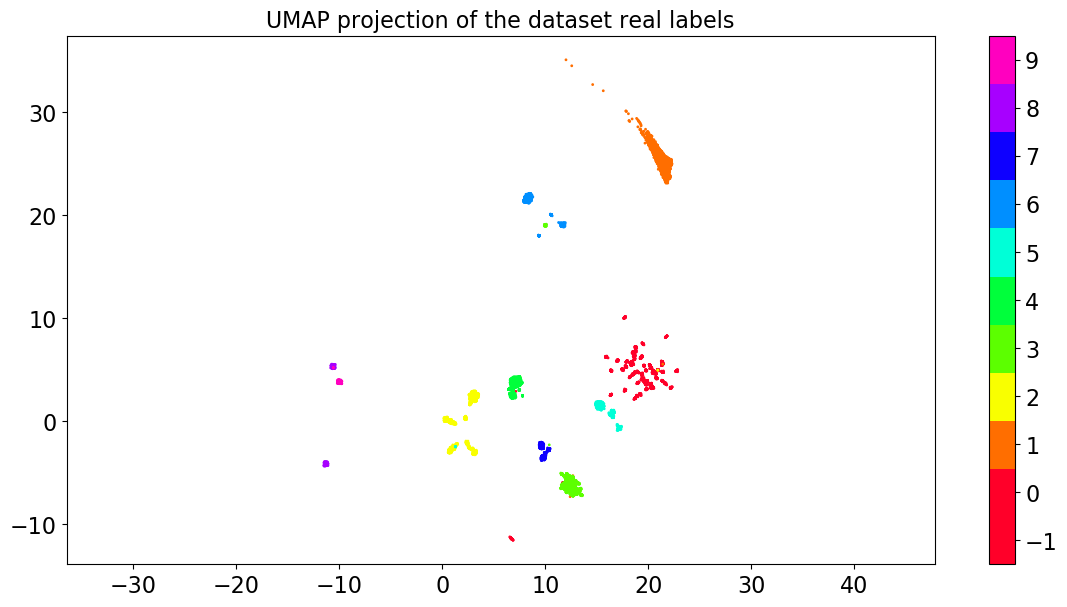

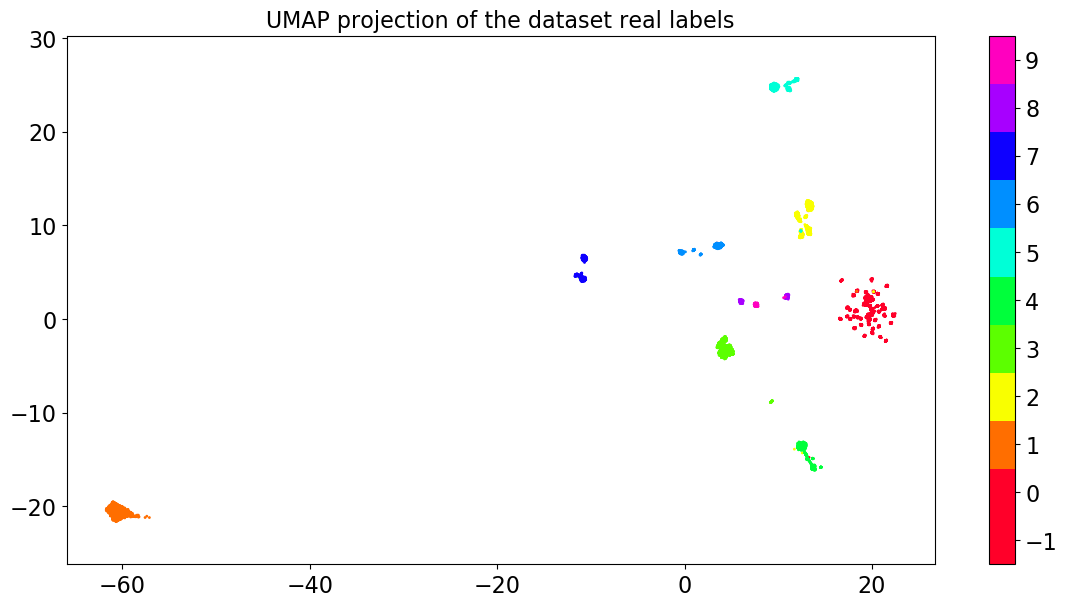

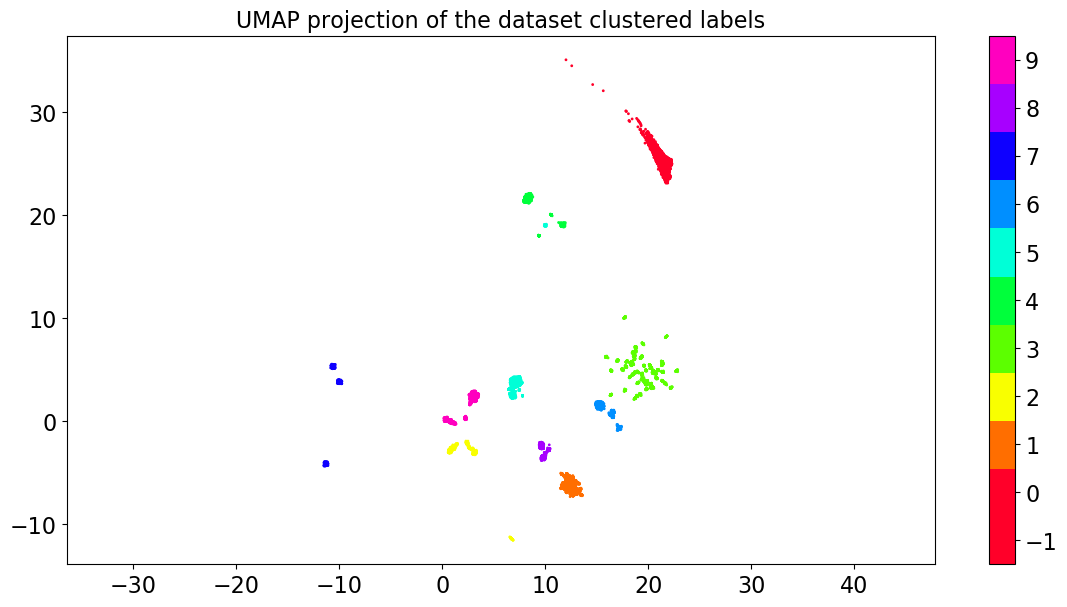

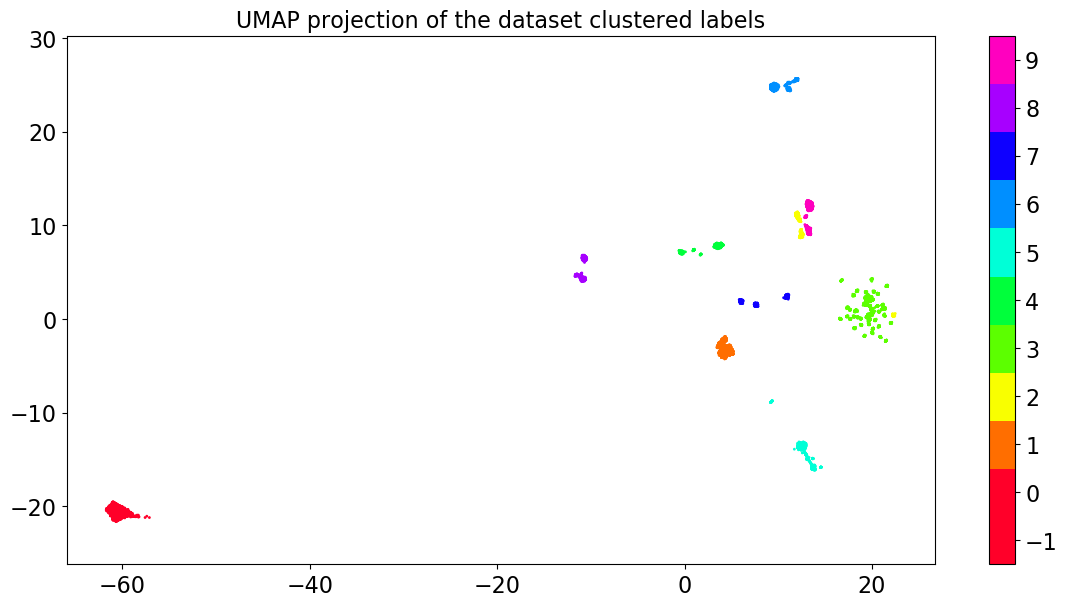

In [35]:
# n_clusters = len(old_clusters)
# k = KMeans(n_clusters).fit(embedding)

n_clusters = len(old_clusters)
k = GaussianMixture(n_clusters).fit(embedding)
k.labels_ = k.predict(embedding)

# k = DBSCAN(0.9).fit(embedding)
# n_clusters = max(k.labels_) + 1

# k = hdbscan.HDBSCAN(min_cluster_size=len(data)//100, gen_min_span_tree=True).fit(embedding)
# n_clusters = max(k.labels_) + 1

# # Visualization of HDBSCAN
# import seaborn as sns
# k.minimum_spanning_tree_.plot(edge_cmap='viridis',
#                                       edge_alpha=0.6,
#                                       node_size=10,
#                                       edge_linewidth=1)
# plt.show()

# k.condensed_tree_.plot()
# plt.show()

# k.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
# plt.show()

rcParams['figure.figsize'] = 14, 7
rcParams['figure.dpi'] = 100
rcParams.update({'font.size': 16})

plt.scatter(embedding[:, 0], embedding[:, 1], c=old_labels, s=1, cmap='gist_rainbow')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
plt.title('UMAP projection of the dataset real labels', fontsize=16)
plt.show()

if embedding.shape[1] >= 4:
    plt.scatter(embedding[:, 2], embedding[:, 3], c=old_labels, s=1, cmap='gist_rainbow')
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
    plt.title('UMAP projection of the dataset real labels', fontsize=16)
    plt.show()

plt.scatter(embedding[:, 0], embedding[:, 1], c=k.labels_, s=1, cmap='gist_rainbow')
# plt.scatter(embedding[:, 0], embedding[:, 1], c=old_labels, s=1, cmap='gist_rainbow')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
plt.title('UMAP projection of the dataset clustered labels', fontsize=16)
plt.show()

if embedding.shape[1] >= 4:
    plt.scatter(embedding[:, 2], embedding[:, 3], c=k.labels_, s=1, cmap='gist_rainbow')
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
    plt.title('UMAP projection of the dataset clustered labels', fontsize=16)
    plt.show()

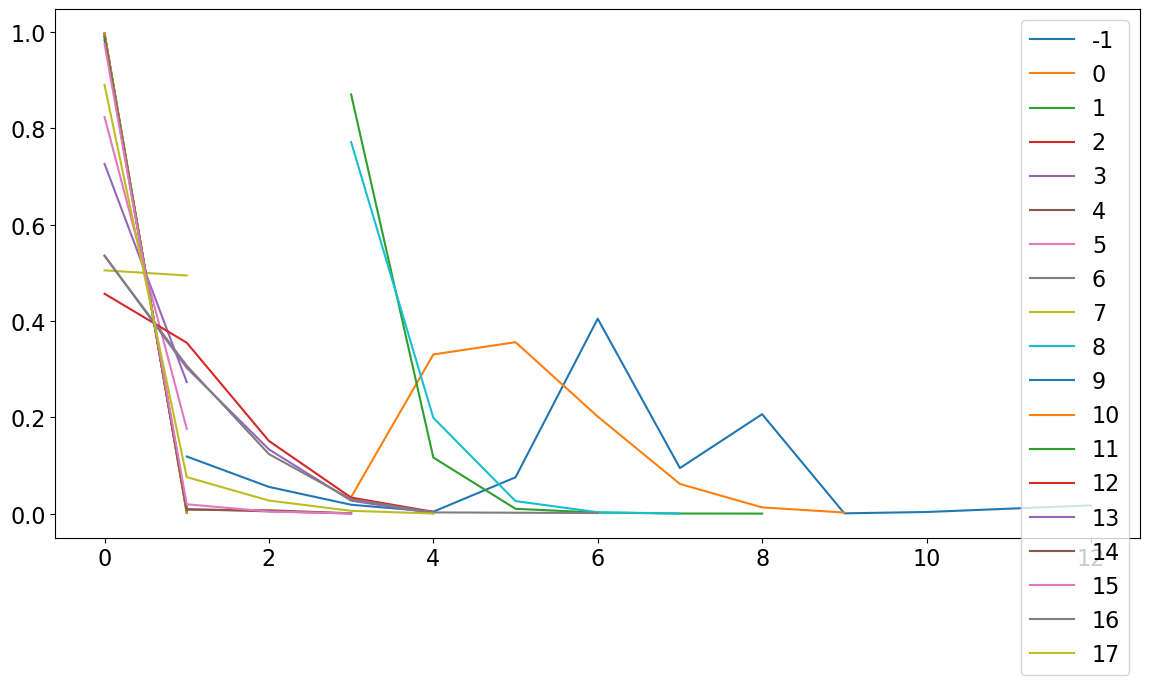

In [14]:
# print(f"number of approvals per cluster: {np.sum(cluster_mean, 1)}")
cluster_size = Counter(k.labels_) 

distance = {i:{} for i in range(-1,n_clusters)}
cluster_centers_ = [np.mean(data[k.labels_ == i],0) for i in range(n_clusters)]
for c, ballot in zip(k.labels_, data):
    dis = int(np.abs(ballot - cluster_centers_[c]).sum())
    try:
        distance[c][dis] += 1/cluster_size[c]
    except KeyError:
        distance[c][dis] = 1/cluster_size[c]
        
for c, dist in distance.items():
    plt.plot(*zip(*sorted(dist.items())), label=c)
plt.legend()
plt.show()

0
{0: 0.8699866310160428, 1: 0.8211898395721925, 2: 0.21913992869875223, 3: 0.9057486631016043, 4: 0.22092245989304812, 5: 0.22025401069518716, 6: 0.2196969696969697, 7: 0.2192513368983957, 8: 0.21858288770053477, 9: 0.21735739750445632, 10: 0.9302584670231729, 11: 0.6765819964349377, 12: 0.9435160427807486, 13: 0.8784536541889483, 14: 0.7643716577540107, 15: 0.9861853832442068, 16: 0.9895276292335116, 17: 0.8284313725490197, 18: 0.2123440285204991, 19: 0.6444964349376114}
8976


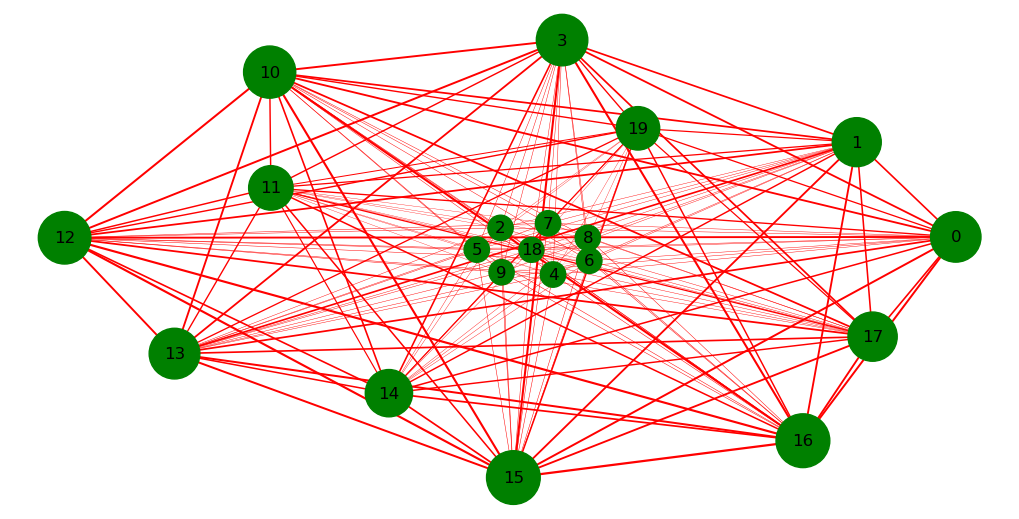

1
{0: 0.9894533571004159, 1: 0.5668449197860963, 2: 0.9922756981580511, 3: 0.9549910873440285, 4: 0.5620915032679739, 5: 0.9950980392156863, 6: 0.9943553178847296, 7: 0.5641711229946524, 8: 0.5715983363042186, 9: 0.5972964943553178, 10: 0.9968805704099821, 11: 0.5545157456922163, 12: 0.9980689245395128, 13: 0.000445632798573975, 14: 0.0005941770647653001, 15: 0.5601604278074866, 16: 0.9903446226975638, 17: 0.0010398098633392751, 18: 0.05095068330362448, 19: 0.000445632798573975}
6732


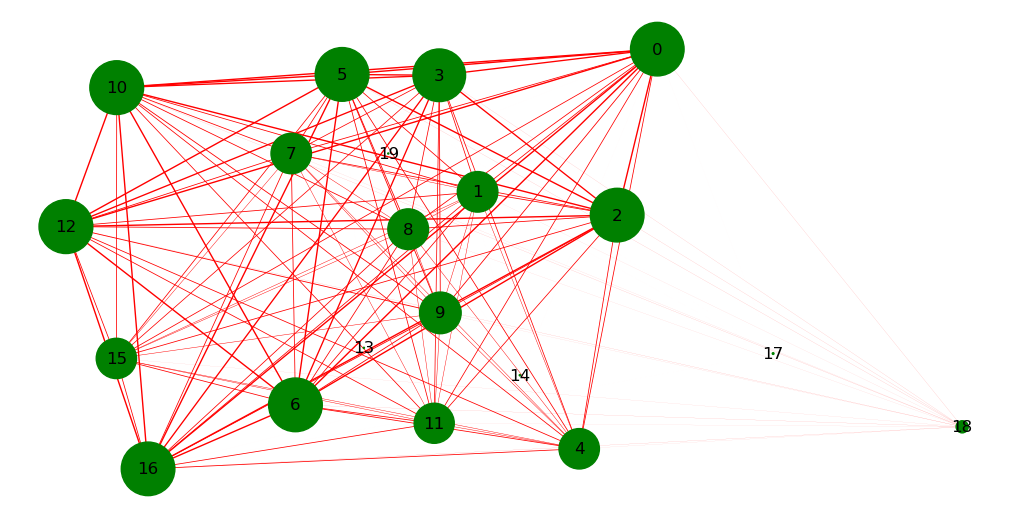

2
{0: 1.0, 1: 1.0, 2: 0.9976762199845082, 3: 0.0, 4: 0.0, 5: 0.0, 6: 1.0, 7: 0.0, 8: 0.0, 9: 1.0, 10: 0.9976762199845082, 11: 0.004647560030983733, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 1.0}
1291


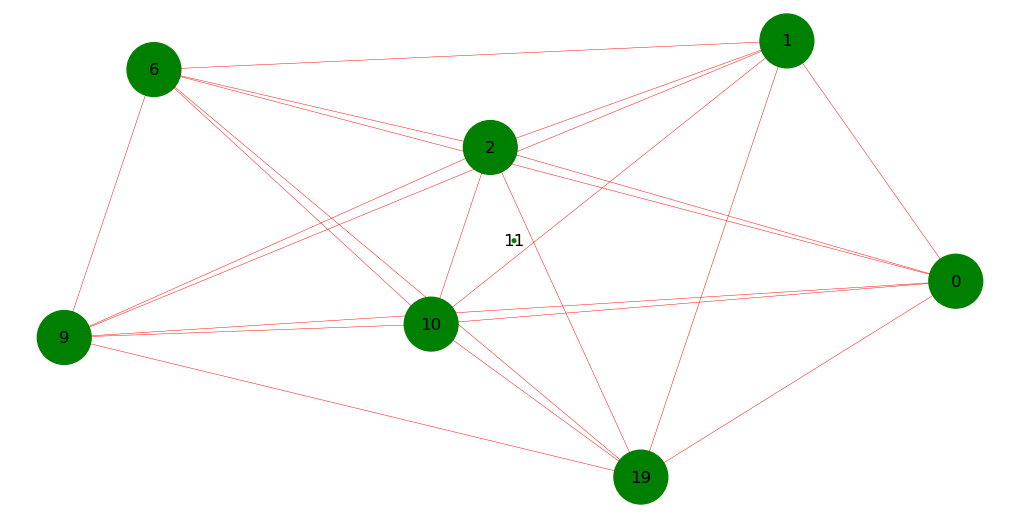

3
{0: 0.2734741784037559, 1: 1.0, 2: 0.994131455399061, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.9653755868544601, 7: 0.0, 8: 0.0, 9: 1.0, 10: 0.9776995305164319, 11: 1.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.7893192488262911}
1704


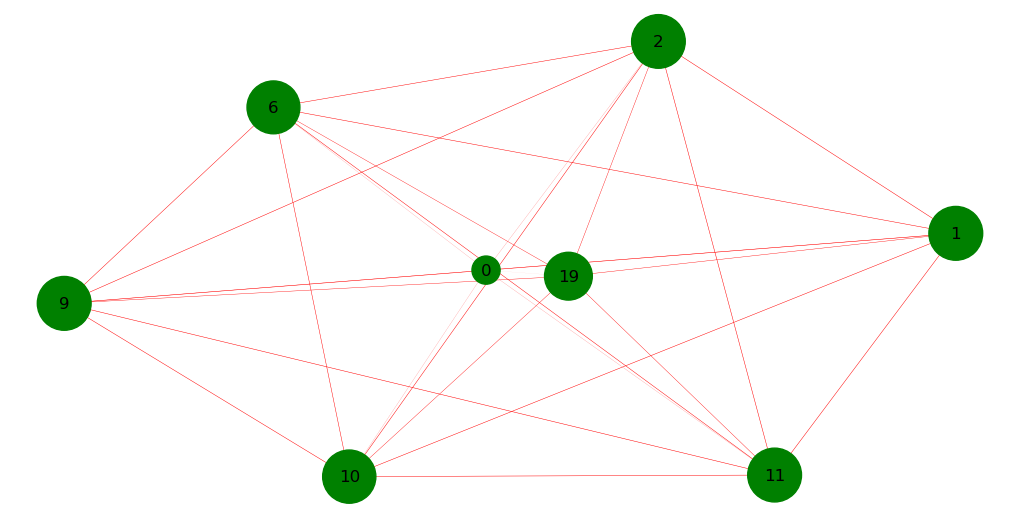

4
{0: 1.0, 1: 0.0, 2: 1.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0003695491500369549, 8: 0.9907612712490761, 9: 0.0, 10: 1.0, 11: 0.0, 12: 0.0003695491500369549, 13: 0.0, 14: 0.0, 15: 0.009238728750923873, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0003695491500369549}
2706


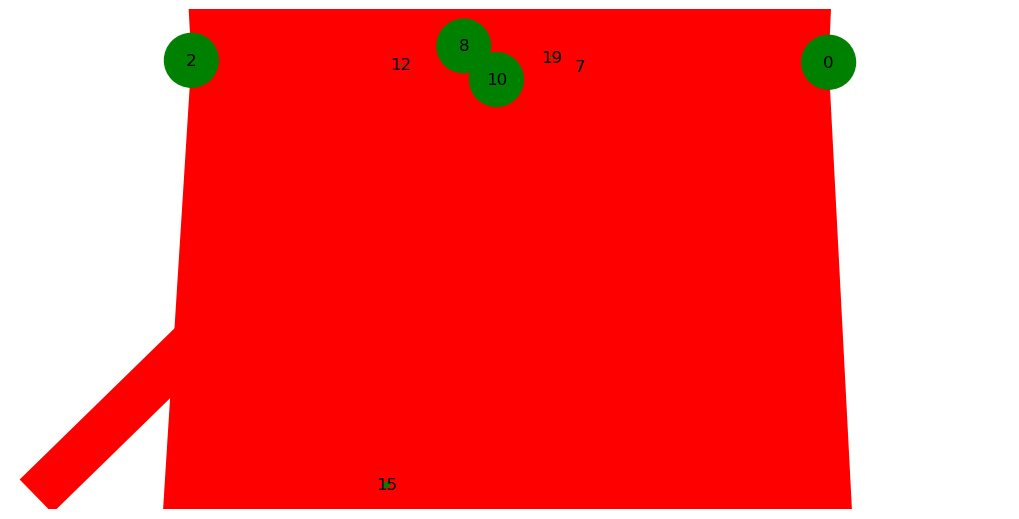

5
{0: 0.17623918174665618, 1: 0.0, 2: 0.9284028324154209, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.992918961447679, 9: 0.0, 10: 0.9024390243902439, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 1.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0}
1271


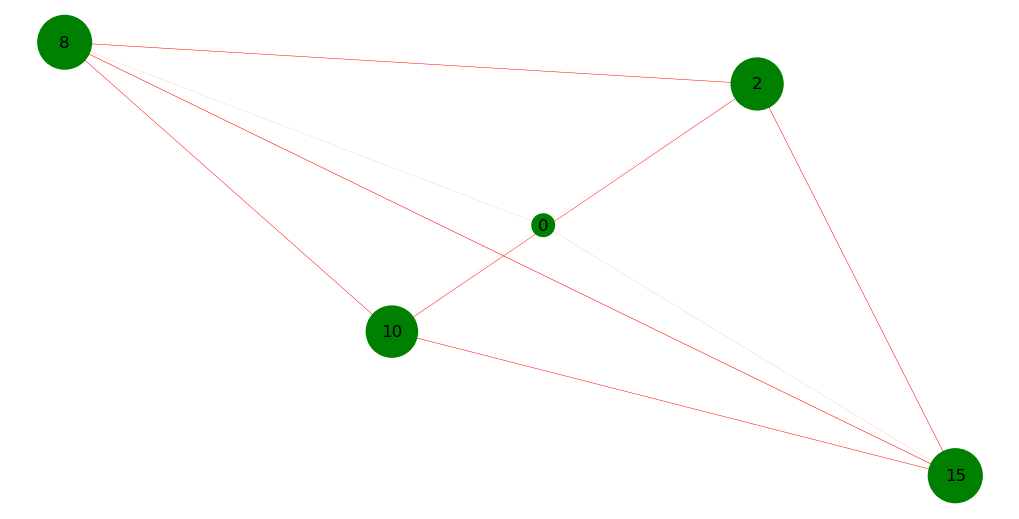

6
{0: 0.9996988858777477, 1: 0.998193315266486, 2: 1.0, 3: 0.9984944293887383, 4: 1.0, 5: 0.9978922011442337, 6: 0.0, 7: 0.0057211683227943394, 8: 0.0, 9: 0.0, 10: 0.0, 11: 1.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 1.0, 19: 0.0}
3321


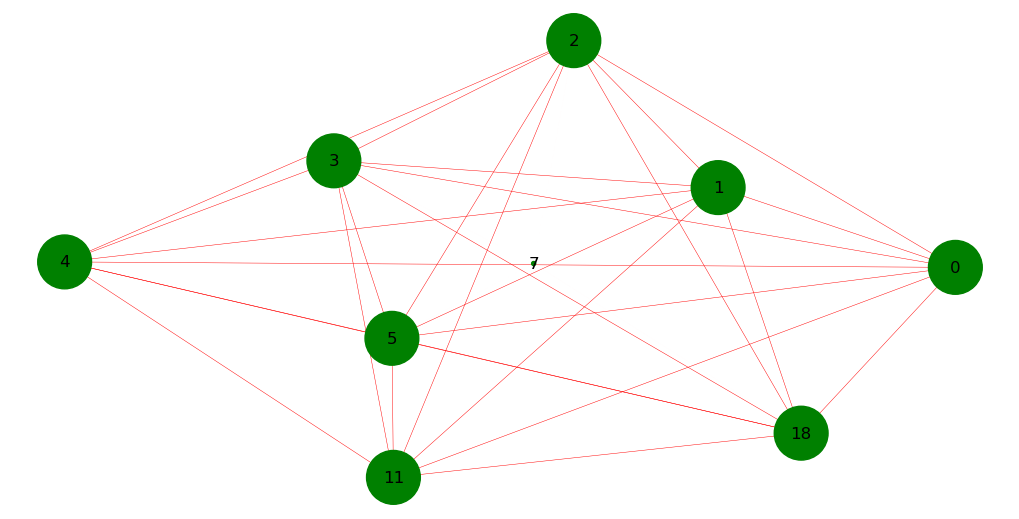

7
{0: 1.0, 1: 0.9950217797137524, 2: 0.8332296204107031, 3: 0.9943995021779714, 4: 0.6876166770379589, 5: 0.9950217797137524, 6: 0.0, 7: 1.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 1.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.49471064094586187, 19: 0.0}
1607


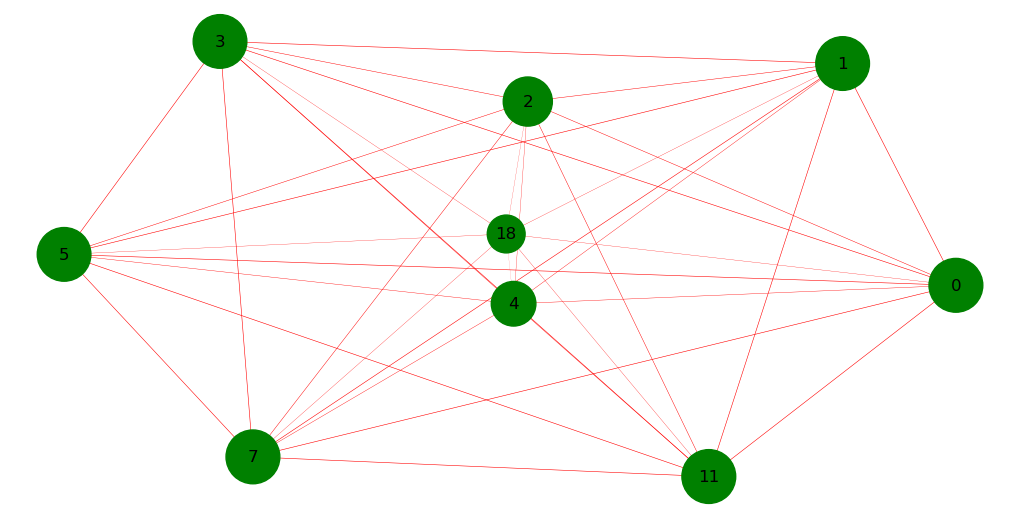

8
{0: 0.9990532295392384, 1: 0.0, 2: 0.944876919840101, 3: 0.9555017883442036, 4: 0.9880075741636861, 5: 0.5012623606143488, 6: 0.9868504102671997, 7: 0.9761203450452346, 8: 0.9914790658531454, 9: 0.49011150852093416, 10: 0.928150641699979, 11: 0.5032610982537344, 12: 0.4915842625710078, 13: 0.6247633073848096, 14: 0.492951819903219, 15: 0.0, 16: 0.00010519671786240269, 17: 0.0014727540500736377, 18: 0.0, 19: 0.945402903429413}
9506


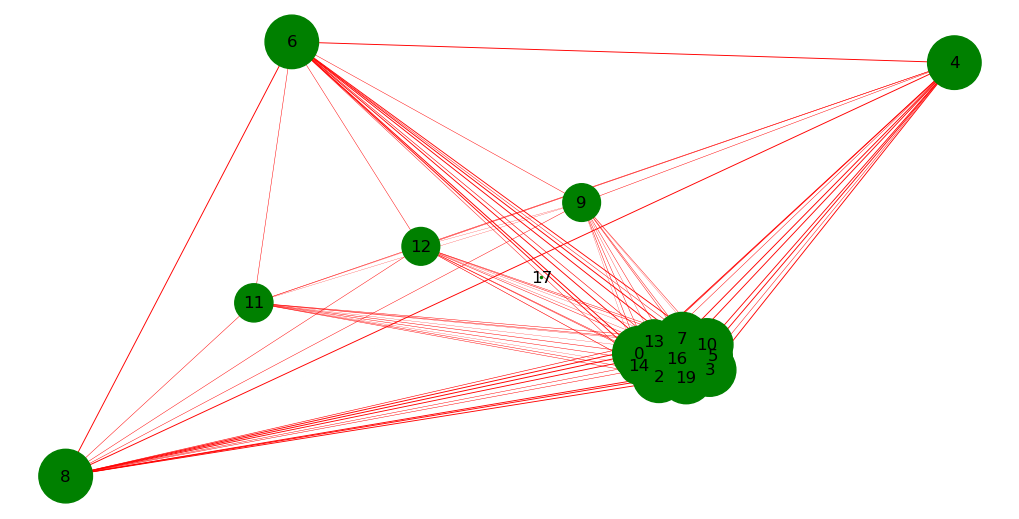

9
{0: 0.0020181634712411706, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.9979818365287588, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 1.0, 19: 0.0}
991


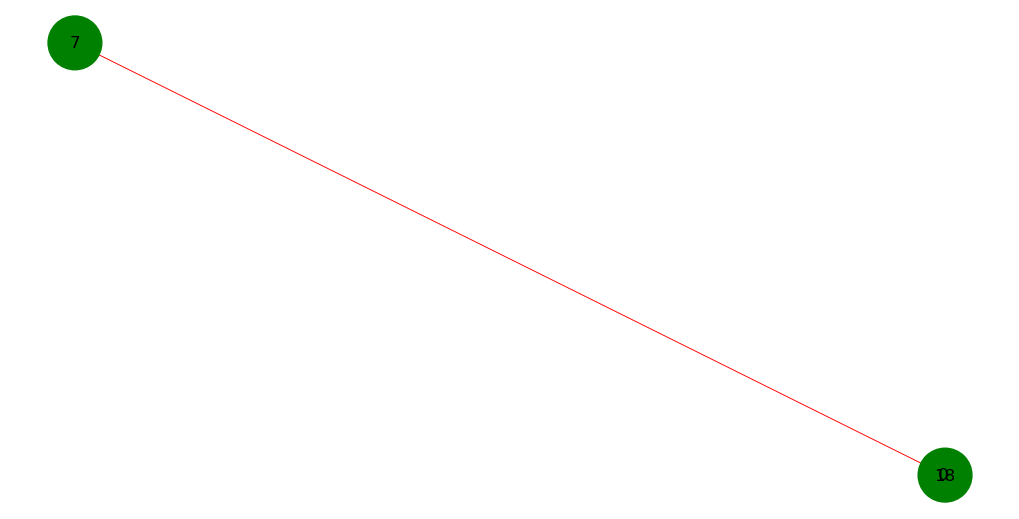

10
{0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0019860973187686196, 7: 0.9980139026812314, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0}
1007


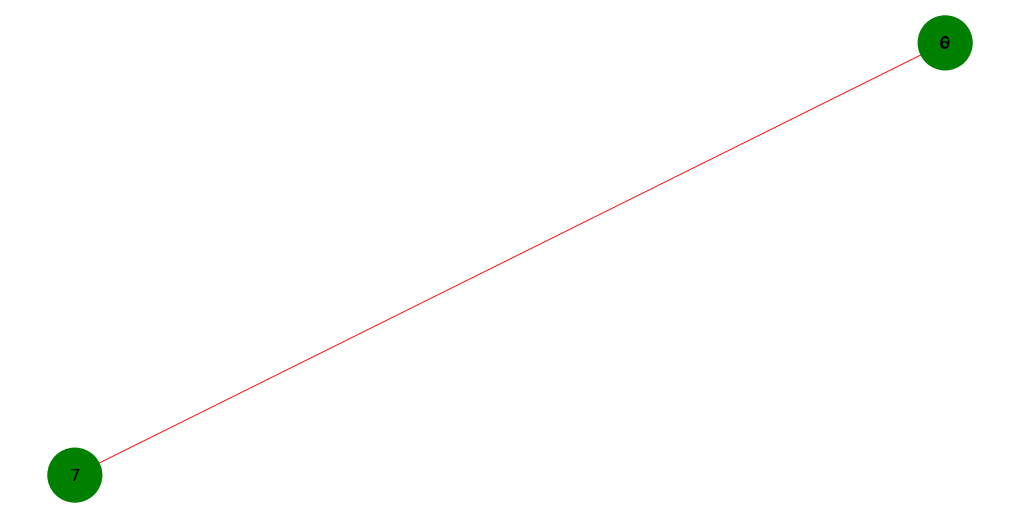

11
{0: 1.0, 1: 0.0, 2: 0.0, 3: 0.9910179640718563, 4: 0.0, 5: 0.0, 6: 0.00499001996007984, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.003992015968063872, 19: 0.0}
1002


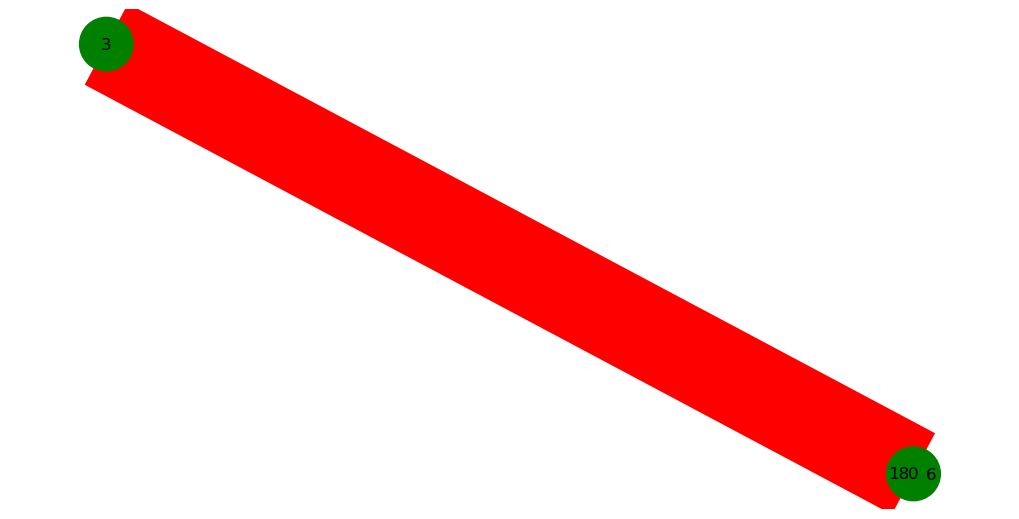

12
{0: 0.952959028831563, 1: 0.9802731411229135, 2: 0.8975720789074355, 3: 0.9871016691957512, 4: 0.9734446130500759, 5: 0.9764795144157815, 6: 0.0, 7: 0.9537177541729894, 8: 0.9415781487101669, 9: 0.8619119878603946, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.8072837632776935, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.8884673748103187, 19: 0.0}
1318


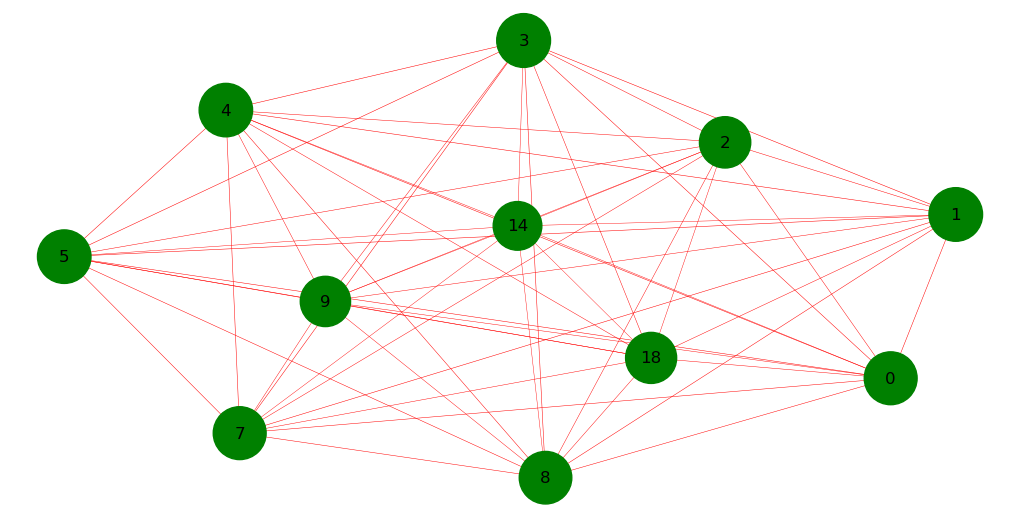

13
{0: 0.9629130141604855, 1: 0.9898853674983142, 2: 0.8907619689817937, 3: 0.9817936614969656, 4: 0.978422117329737, 5: 0.9871881321645314, 6: 1.0, 7: 0.9703304113283884, 8: 0.956844234659474, 9: 0.9069453809844908, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.8064733648010789, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.9015509103169251, 19: 0.0}
1483


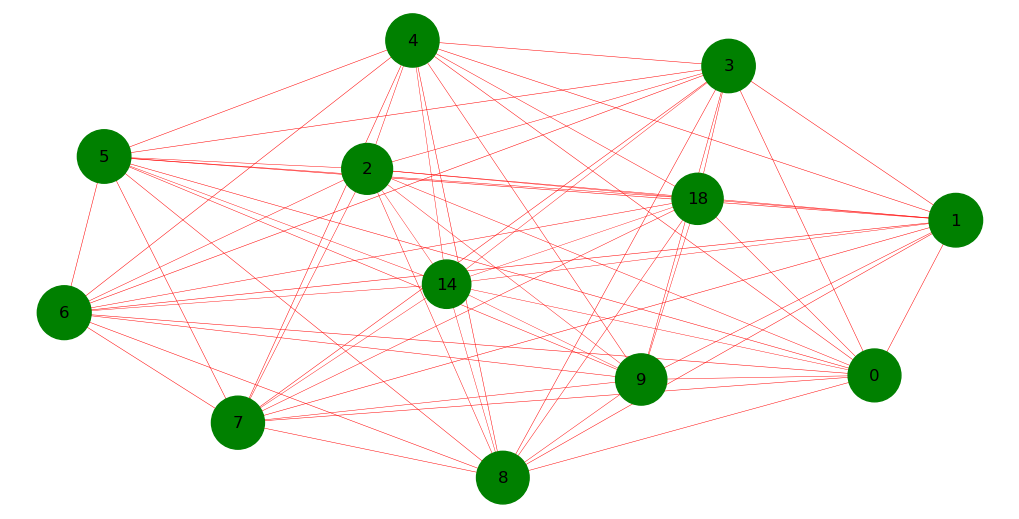

14
{0: 0.9968823070927514, 1: 0.0, 2: 0.9992205767731879, 3: 0.0, 4: 0.9992205767731879, 5: 0.9992205767731879, 6: 0.990646921278254, 7: 0.0, 8: 0.0, 9: 0.9992205767731879, 10: 0.0, 11: 0.000779423226812159, 12: 0.000779423226812159, 13: 0.9992205767731879, 14: 0.011691348402182385, 15: 0.0, 16: 0.003117692907248636, 17: 0.0, 18: 0.0, 19: 0.0}
1283


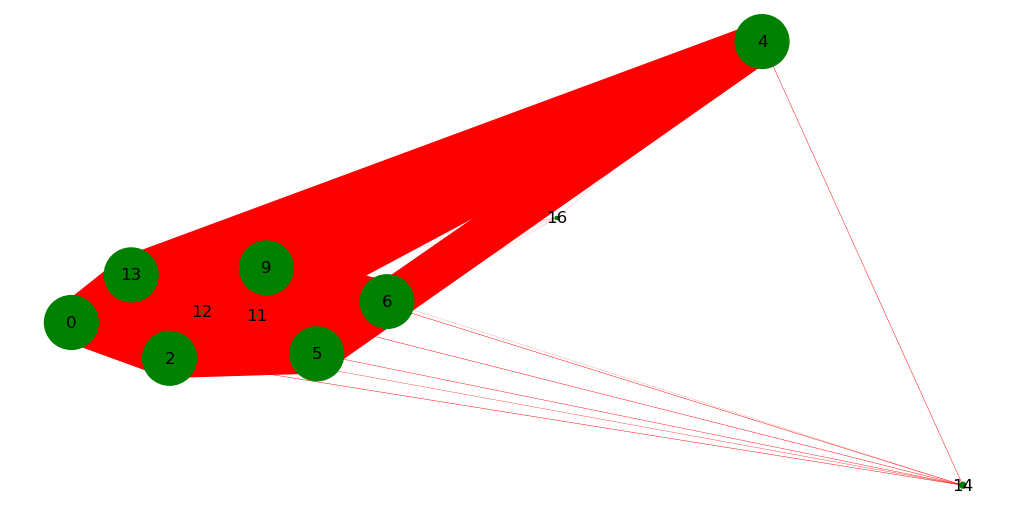

15
{0: 0.995253164556962, 1: 0.0002260397830018083, 2: 0.021247739602169982, 3: 0.0, 4: 0.9923146473779385, 5: 0.9918625678119349, 6: 0.9977396021699819, 7: 0.0, 8: 0.0002260397830018083, 9: 0.9995479204339964, 10: 0.0, 11: 0.0009041591320072332, 12: 0.0, 13: 0.9988698010849909, 14: 1.0, 15: 0.0, 16: 0.002034358047016275, 17: 0.0, 18: 0.0004520795660036166, 19: 0.0}
4424


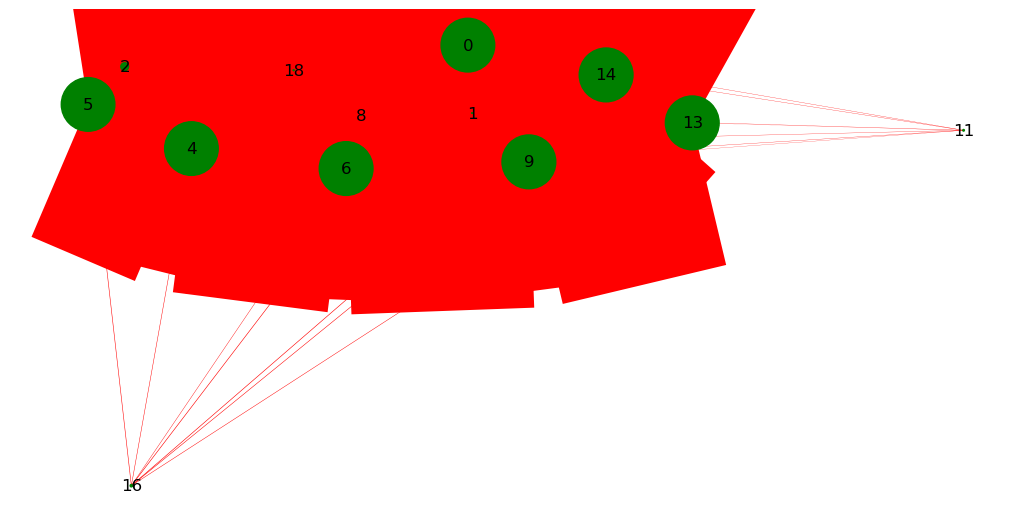

16
{0: 0.9680989583333334, 1: 0.9928385416666666, 2: 0.8997395833333334, 3: 0.9889322916666666, 4: 0.97265625, 5: 0.9915364583333334, 6: 0.0006510416666666666, 7: 0.9615885416666666, 8: 0.9674479166666666, 9: 0.8821614583333334, 10: 0.0, 11: 0.0006510416666666666, 12: 0.0013020833333333333, 13: 1.0, 14: 0.8170572916666666, 15: 0.0006510416666666666, 16: 0.0, 17: 0.0, 18: 0.8854166666666666, 19: 0.0}
1536


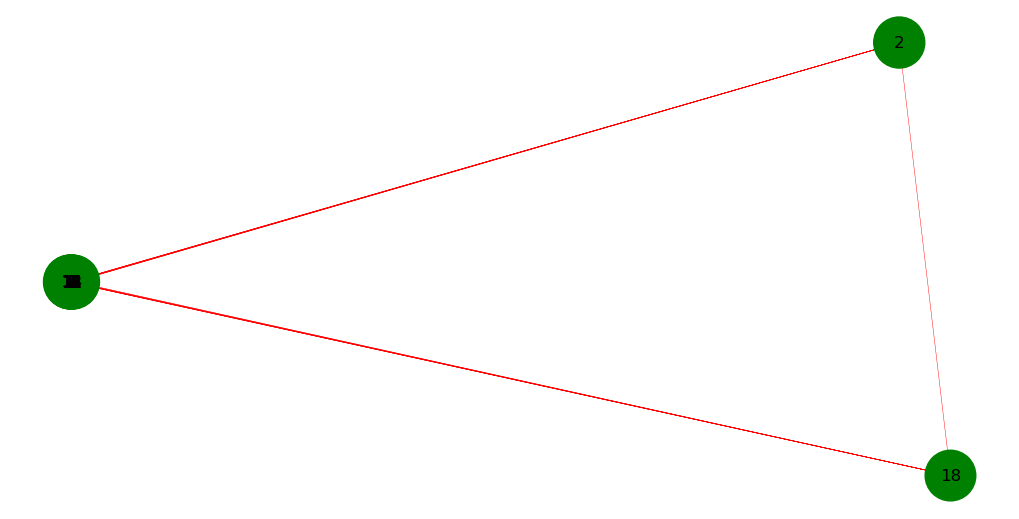

17
{0: 0.9937961595273265, 1: 0.9940915805022157, 2: 0.9672082717872968, 3: 0.9946824224519941, 4: 0.991728212703102, 5: 0.9970457902511078, 6: 1.0, 7: 0.9890694239290989, 8: 0.9905465288035451, 9: 0.9689807976366323, 10: 0.0, 11: 0.0, 12: 0.0, 13: 1.0, 14: 1.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.9621861152141802, 19: 0.0}
3385


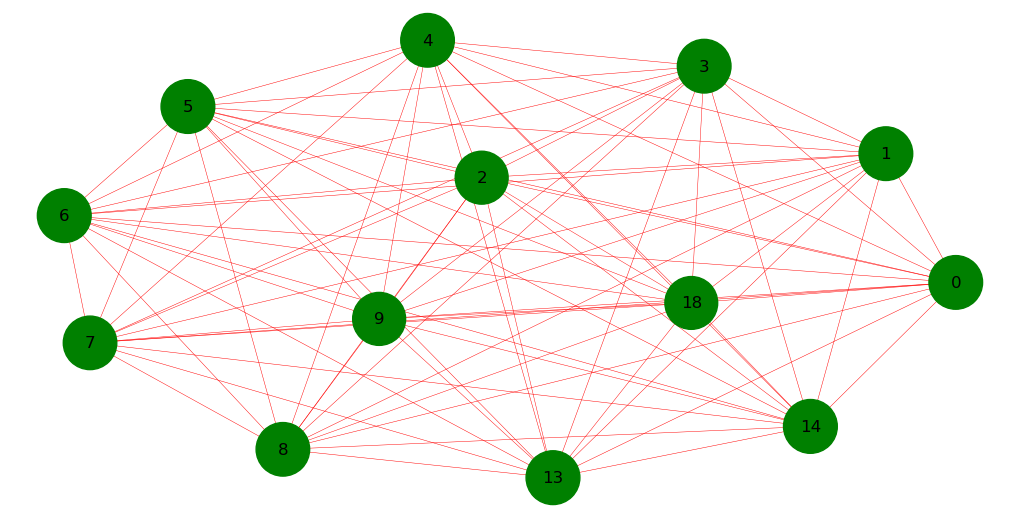

In [15]:
clusters = [data[k.labels_ == i] for i in range(n_clusters)]
# clusters = old_clusters
for see_cluster in range(n_clusters):
    print(see_cluster)
    print({i:x for i,x in enumerate(np.mean(clusters[see_cluster],0))})
    print(len(clusters[see_cluster]))
    cluster_0 = Counter([tuple(np.where(x == 1)[0]) for x in clusters[see_cluster]])

    edge_dict = {}
    for key,value in cluster_0.items():
        for perm in permutations(key, 2):
            try:
                edge_dict[(perm[0], perm[1])] += value
            except KeyError:
                try: 
                    edge_dict[(perm[1], perm[0])] += value
                except KeyError:
                    edge_dict[(perm[0], perm[1])] = value

    edge_list = [(*key, {'weight':value}) for key,value in edge_dict.items()]
    
    G = nx.Graph()
    G.add_nodes_from(sorted(set([y for x in cluster_0.keys() for y in x])))
    G.add_edges_from(edge_list)
    rcParams['figure.figsize'] = 10, 5
    rcParams['figure.dpi'] = 100
    options = {
        'node_color': 'g',
        'edge_color':'r'
    }
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    weights /= np.median(weights)*3
    
    nodes = G.nodes()
    s = np.sum(clusters[see_cluster],0)
    s /= max(s)
    s *= 1500
    node_size = [s[n] for n in nodes]

    nx.draw_kamada_kawai(G, node_size=node_size, with_labels=True, edgelist=edges, width=weights, **options)
    plt.show()
